# Homework 4

## Question 2: Applied ML


### Loading the data
First we load the data and vectorize it.
The library functions contained in sklearn make this very straightforward.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# we use the builtin function for loading data
# sklearn already has a split in train/test, you can specify which data you want with the "subset" parameter
# since we will perform that split ourselves, we load all data
# we also remove all metadata

from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset="all", remove=('headers', 'footers', 'quotes'))

In [3]:
# the newsgroups are an sklearn "bunch"
# it resembles a dictionary
newsgroups.keys()

dict_keys(['target', 'data', 'DESCR', 'description', 'target_names', 'filenames'])

In [4]:
# data contains the text for each article
newsgroups.data[0]

"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

In [5]:
# check how many articles we have
len(newsgroups.data)

18846

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# this will create a vector for every article
# the output is a matrix
matrix = TfidfVectorizer().fit_transform(newsgroups.data)

print(type(matrix))
print(matrix.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(18846, 134410)


### Splitting the data

We split the data into separate sets for training, testing and evaluating.
Following the usual naming convention in machine learning, we call these datasets

 - X_train, y_train
 - X_test, y_test
 - X_val, y_val
 
where X is the data and y contains the labels

In [7]:
# renaming
X = matrix
y = newsgroups.target

In [8]:
# now we do the split into train, test, val
# it's 0.8, 0.1, 0.1

num_samples = len(y)
num_train = int(0.8 * num_samples)
num_test = int(0.1 * num_samples)
num_val = int(0.1 * num_samples)

X_train = X[:num_train]
X_test = X[num_train : -num_val]
X_val = X[-num_val:]


y_train = y[:num_train]
y_test = y[num_train : -num_val]
y_val = y[-num_val:]

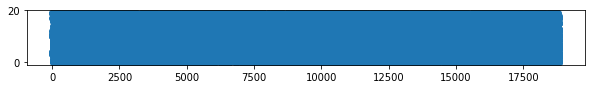

In [9]:
# we know whether the data is ordered
# it would be possible that we have all articles from category 1 first, then category 2, etc
# this would mean that our split is broken
# we take a look at the labels
# the scatterplot shows that there is no order, the labels don't increase linearly
plt.figure(figsize=(10,1))
plt.scatter(np.arange(len(y)), y)
plt.show()

### Fitting a RandomForest

Before we start the grid search, we fit a random forest, to see how the syntax looks.

We also want to check whether the classifier actually works, or if we have made some mistake. There are 20 categories. If the classifier is just guessing randomly, we would see an accuracy of about 1/20 = 5%. If the classifier does better than that, it is able to "learn" the data. That would mean we can continue to search for a good parametrization.

In [10]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [11]:
# use the classifier to predict labels for the test set
pred_test = random_forest.predict(X_test)

In [12]:
# compute the accuracy
comparison = pred_test == y_test
hits = comparison.sum()
accuracy = hits / len(comparison)
print("the accuracy on the test set is: ",accuracy)

the accuracy on the test set is:  0.45652173913


This random forest is able to achieve 46% test accuracy. And this is for top-1 results. It would probably do much better if we would compute something like the top-2 or top-3 accuracy.

The number of estimators is 10 by default. I would like to get the max depth that was used in this tree. Then we can use these parameters as the center of our grid search.

In [13]:
# unfortunately, we are apparently not supposed to read the depth
# it is necessary to use properties with _ in their name
depths = [estimator.tree_.max_depth for estimator in random_forest.estimators_]


max_depth = max(depths)
avg_depth = sum(depths)/len(depths)

print("max depth is: ", max_depth)
print("avg depth is: ", avg_depth)

max depth is:  609
avg depth is:  496.2


### Gridsearch

We use the parameters given above to set up our gridsearch.
The number of estimators is 10 by default. It seems reasonable to look at numbers from 5 to 15.
That means 50% above and 50% below.

So far the maximum depth was 550. We are changing the number of estimators, but I don't expect the maximum depth to go much higher than this. So I'm limiting it to 700.

In [14]:
n_estimators = np.arange(10)+5
max_depths = 7 * np.logspace(1, 2, num=10)

In [15]:
n_estimators

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [16]:
max_depths

array([  70.        ,   90.40847655,  116.7670376 ,  150.8104283 ,
        194.77915815,  251.56695647,  324.91121835,  419.63897522,
        541.98457788,  700.        ])

In [22]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from scipy.sparse import vstack

In [35]:
train_indices = [0] * X_train.shape[0]
test_indices = [1] * X_test.shape[0]
indices = train_indices + test_indices

X_joint = vstack([X_train, X_test])
y_joint = np.concatenate([y_train, y_test])

pds = PredefinedSplit(indices)

In [ ]:
rerun = True

if rerun:
    
    rfc = RandomForestClassifier()
    clf_grid = GridSearchCV(rfc, param_grid={'n_estimators':n_estimators, 'max_depth':max_depths}, cv=pds)
    clf_grid.fit(X_joint, y_joint)